In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [109]:
ts = pd.read_csv('datasets/time_series/renewables_series.csv')
ts['date'] = pd.to_datetime(ts['date'])
ts.set_index('date', inplace=True)
ts.head(2)

,solar,wind,geothermal,biomass,biogas
date,,,,,
2018-04-12 00:00:00,0.0,4228.0,706.0,242.0,242.0
2018-04-12 00:05:00,0.0,4196.0,716.0,238.0,242.0


### Calculate mean megawatt demand each hour
- This allows for forecasting data in megawatt hours in future methods

In [110]:
mwh = ts.resample('H').mean()
print(mwh.shape)
mwh.head(2)

(18504, 5)


,solar,wind,geothermal,biomass,biogas
date,,,,,
2018-04-12 00:00:00,0.0,4334.916667,688.25,243.166667,241.333333
2018-04-12 01:00:00,0.0,4197.000000,654.75,236.916667,241.083333


### Read in weather data

In [111]:
uv = pd.read_csv('datasets/time_series/solar_test.csv')
uv['date'] = pd.to_datetime(uv['date'],format='%Y-%m-%dT%H:%M:%S')
uv.set_index('date',inplace=True)
uv.index = pd.to_datetime(uv.index)
print(uv.shape)

(768, 61)


In [48]:
uv['total_uv'] = uv.sum(axis=1)

In [49]:
test = pd.merge(uv,mwh['solar'],how='left',left_index=True, right_index=True)
print(test.shape)
test.head(2)

(768, 63)

In [52]:
uv_test = test[['total_uv','solar']]

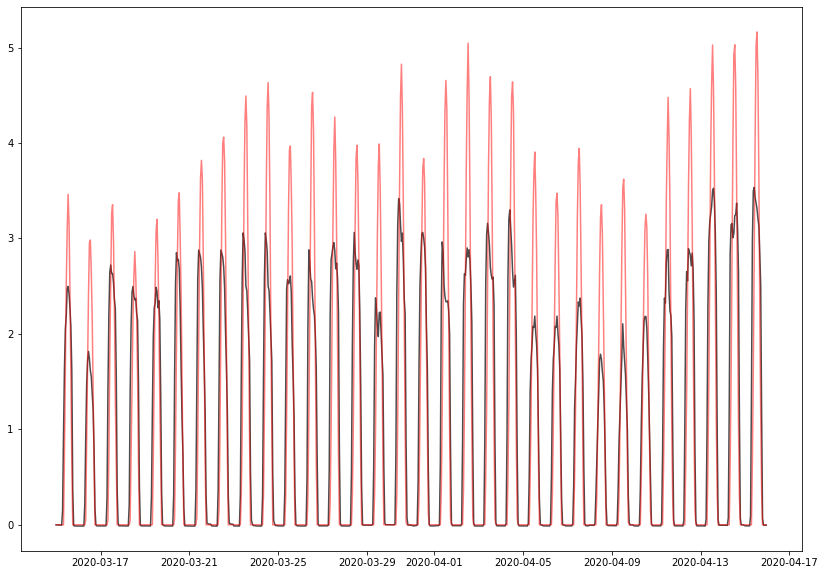

In [63]:
plt.figure(figsize=(14,10))
plt.plot(uv_test.index,uv_test['solar']/np.mean(uv_test['solar']),'k-',alpha=0.7)
plt.plot(uv_test.index,uv_test['total_uv']/np.mean(uv_test['total_uv']),'r-',alpha=0.5)

In [65]:
uv_daily = uv_test.resample('D').sum()

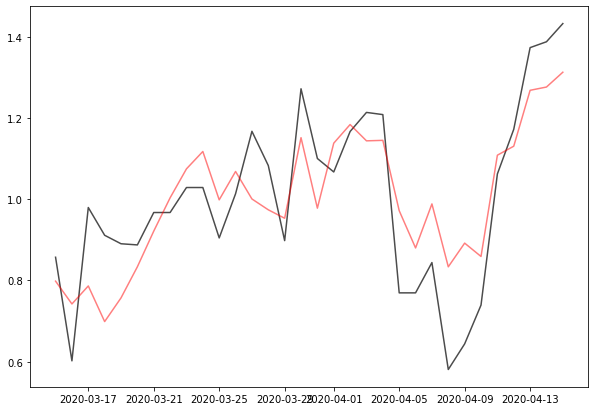

In [67]:
plt.figure(figsize=(10,7))
plt.plot(uv_daily.index,uv_daily['solar']/np.mean(uv_daily['solar']),'k-',alpha=0.7)
plt.plot(uv_daily.index,uv_daily['total_uv']/np.mean(uv_daily['total_uv']),'r-',alpha=0.5)

### Linear Regression 1
- just total_uv


In [68]:
uv_test.corr()

,total_uv,solar
total_uv,1.000000,0.863767
solar,0.863767,1.000000


In [157]:
X = uv_test['total_uv'].astype('float64').values.reshape(-1,1)
y = uv_test['solar'].astype('float64').values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,shuffle=False)

In [158]:
lr = LinearRegression()
lr.fit(X_train,y_train)
preds = lr.predict(X_test)

RMSE = 1793.5472763518724


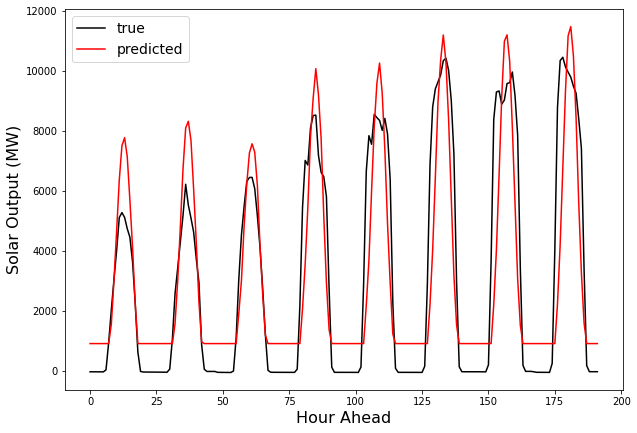

In [159]:
print(f"RMSE = {np.sqrt(mean_squared_error(y_test, preds))}")
plt.figure(figsize=(10,7))
plt.plot(y_test,'k-',label='true')
plt.plot(preds,'r-',label='predicted')
plt.legend(fontsize=14)
plt.xlabel('Hour Ahead',fontsize=16)
plt.ylabel('Solar Output (MW)',fontsize=16);

### Linear regression 2
- add 4 part time of day dummy variable

In [161]:
uv2 = uv_test.copy()

In [162]:
# morning = 6am-10am
uv2['morning'] = [1 if int(t)>6 and int(t)<=10 else 0 for t in uv2.index.hour]
# midday = 10am-3pm
uv2['midday'] = [1 if int(t)>10 and int(t)<=15 else 0 for t in uv2.index.hour]
# afternoon = 3pm-7pm
uv2['afternoon'] = [1 if int(t)>15 and int(t)<=19 else 0 for t in uv2.index.hour]
# night = 7pm-6am
uv2['night'] = [1 if int(t)>19 or int(t)<=6 else 0 for t in uv2.index.hour]

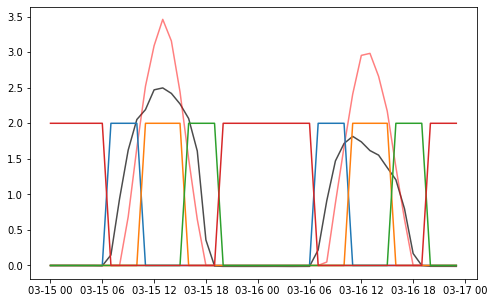

In [163]:
plt.figure(figsize=(8,5))
plt.plot(uv_test.index[0:48],uv_test['solar'][0:48]/np.mean(uv_test['solar']),'k-',alpha=0.7)
plt.plot(uv_test.index[0:48],uv_test['total_uv'][0:48]/np.mean(uv_test['total_uv']),'r-',alpha=0.5)
plt.plot(uv2.index[0:48], uv2['morning'][0:48]*2)
plt.plot(uv2.index[0:48], uv2['midday'][0:48]*2)
plt.plot(uv2.index[0:48], uv2['afternoon'][0:48]*2)
plt.plot(uv2.index[0:48], uv2['night'][0:48]*2)

In [164]:
X = uv2.drop(columns='solar')
y = uv2['solar']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,shuffle=False)

In [165]:
lr = LinearRegression()
lr.fit(X_train,y_train)
preds = lr.predict(X_test)

RMSE = 1227.5309196196308


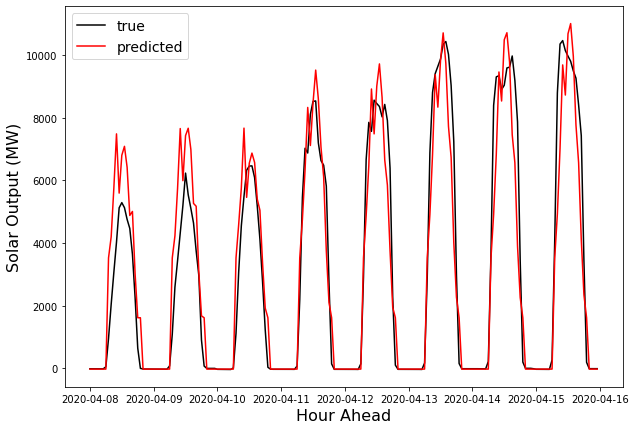

In [166]:
print(f"RMSE = {np.sqrt(mean_squared_error(y_test, preds))}")
plt.figure(figsize=(10,7))
plt.plot(y_test.index,y_test,'k-',label='true')
plt.plot(y_test.index,preds,'r-',label='predicted')
plt.legend(fontsize=14)
plt.xlabel('Hour Ahead',fontsize=16)
plt.ylabel('Solar Output (MW)',fontsize=16);

### RNN model
- engineer new columns: hour of day, month, 